In [1]:
!nvidia-smi

Mon Apr  8 02:49:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
import PIL
import glob, os, shutil, random

2024-04-08 02:49:17.965620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 02:49:17.965678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 02:49:17.967361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [3]:
path = '/kaggle/input/dog-classification-real-fake'
train_path = '/kaggle/input/dog-classification-real-fake/train'
valid_path = '/kaggle/input/dog-classification-real-fake/valid'
test_path = '/kaggle/input/dog-classification-real-fake/test'

In [4]:
img_width, img_height = 224, 224
batch_size = 64
num_classes = 1
last_activation = 'sigmoid'

train_ds = image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    # label_mode='binary'
)

valid_ds = image_dataset_from_directory(
    valid_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    # label_mode='binary'
)

test_ds = image_dataset_from_directory(
    test_path,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    # label_mode='binary'
)

Found 991 files belonging to 2 classes.
Found 335 files belonging to 2 classes.
Found 321 files belonging to 2 classes.


In [5]:
labels = train_ds.class_names
labels

['fake', 'real']

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), (y, y, y)))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), (y, y, y)))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
print(AUTOTUNE)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

-1


# GoogLeNet

In [8]:
def inception(input_layer, filter, name):

  step = str(input_layer)

  tower_1 = layers.Conv2D(filters=filter[0], kernel_size=(1, 1), strides=1, padding='same', activation='relu', name=f'inception_{name}_t1_c1')(input_layer)

  tower_2 = layers.Conv2D(filters=filter[1][0], kernel_size=(1, 1), strides=1, padding='same', activation='relu', name=f'inception_{name}_t2_c1')(input_layer)
  tower_2 = layers.Conv2D(filters=filter[1][1], kernel_size=(3, 3), strides=1, padding='same', activation='relu', name=f'inception_{name}_t2_c2')(tower_2)

  tower_3 = layers.Conv2D(filters=filter[2][0], kernel_size=(1, 1), strides=1, padding='same', activation='relu', name=f'inception_{name}_t3_c1')(input_layer)
  tower_3 = layers.Conv2D(filters=filter[2][1], kernel_size=(5, 5), strides=1, padding='same', activation='relu', name=f'inception_{name}_t3_c2')(tower_3)

  tower_4 = layers.MaxPool2D(pool_size=(3, 3), strides=1, padding='same', name=f'inception_{name}_t4_p1')(input_layer)
  tower_4 = layers.Conv2D(filters=filter[3], kernel_size=(1, 1), strides=1, padding='same', activation='relu', name=f'inception_{name}_t4_c1')(tower_4)

  concat_layer = layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3, name=f'inception_{name}_concat')

  return concat_layer

In [9]:
def auxiliary_networks(input_layer, name):

  avg_pool = layers.AveragePooling2D(pool_size=(5, 5), strides=3, padding='valid', name=f'aux_{name}_pool')(input_layer)
  conv_layer = layers.Conv2D(filters=128, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name=f'aux_{name}_conv')(avg_pool)
  flatten = layers.Flatten(name=f'aux_{name}_fc')(conv_layer)
  fc_layer = layers.Dense(1024, activation='relu', name=f'aux_{name}_dense1')(flatten)
  dropout_layer = layers.Dropout(0.7, name=f'aux_{name}_dropout')(fc_layer)
  output_layer = layers.Dense(num_classes, activation=last_activation, name=f'aux_{name}_output')(dropout_layer)

  return output_layer

In [10]:
filters_3a = (64, [96, 128], [16, 32], 32)
filters_3b = (128, [128, 192], [32, 96], 64)
filters_4a = (192, [96, 208], [16, 48], 64)
filters_4b = (160, [112, 224], [24, 64], 64)
filters_4c = (128, [128, 256], [24, 64], 64)
filters_4d = (112, [144, 288], [32, 64], 64)
filters_4e = (256, [160, 320], [32, 128], 128)
filters_5a = (256, [160, 320], [32, 128], 128)
filters_5b = (384, [192, 384], [48, 128], 128)

In [11]:
def googlenet():
    
    input_layer = layers.Input(shape = (img_width, img_height, 3), name='input_layer')

    conv_1 = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation='relu', name='conv_1')(input_layer)
    maxpool_1 = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same', name='maxpool_1')(conv_1)
    conv_2 = layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='valid', activation='relu', name='conv_2')(maxpool_1)
    conv_3 = layers.Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu', name='conv_3')(conv_2)
    maxpool_2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same', name='maxpool_2')(conv_3)

    concat_layer_3a = inception(maxpool_2, filters_3a, '3a') # 3a
    concat_layer_3b = inception(concat_layer_3a, filters_3b, '3b') # 3b

    maxpool_3 = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same', name='maxpool_3')(concat_layer_3b)

    concat_layer_4a = inception(maxpool_3, filters_4a, '4a') # 4a
    aux_layer_4a = auxiliary_networks(concat_layer_4a, '4a')
    concat_layer_4b = inception(concat_layer_4a, filters_4b, '4b') # 4b
    concat_layer_4c = inception(concat_layer_4b, filters_4c, '4c') # 4c
    concat_layer_4d = inception(concat_layer_4c, filters_4d, '4d') # 4d
    aux_layer_4d = auxiliary_networks(concat_layer_4d, '4d')
    concat_layer_4e = inception(concat_layer_4d, filters_4e, '4e') # 4e

    maxpool_4 = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same', name='maxpool_4')(concat_layer_4e)

    concat_layer_5a = inception(maxpool_4, filters_5a, '5a') # 5a
    concat_layer_5b = inception(concat_layer_5a, filters_5b, '5b') # 5b

    avgpool = layers.AveragePooling2D(pool_size=(7, 7), strides=1, padding='valid', name='avgpool')(concat_layer_5b)

    dropout_layer = layers.Dropout(0.4, name='dropout')(avgpool)
    flat_layer = layers.Flatten(name='fc')(dropout_layer)
    dense_layer = layers.Dense(1024, activation='relu', name='dense')(flat_layer)
    output_layer = layers.Dense(num_classes, activation=last_activation, name='main_output')(dense_layer)

    google_net_model = models.Model(inputs=input_layer, outputs =[output_layer, aux_layer_4a, aux_layer_4d])
    google_net_model.summary()
    
    return google_net_model

# Model Training

In [12]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs : {mirrored_strategy.num_replicas_in_sync}")

Number of GPUs : 2


In [13]:
losses = {"main_output": "binary_crossentropy", 
          "aux_4a_output": "binary_crossentropy", 
          "aux_4d_output": "binary_crossentropy"}
loss_weights = {"main_output": 1.0, "aux_4a_output": 0.3, "aux_4d_output": 0.3}
metrics = {"main_output": "accuracy", 
          "aux_4a_output": "accuracy", 
          "aux_4d_output": "accuracy"}

In [14]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    
    google_net_model = googlenet()
    
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    google_net_model.compile(loss=losses,
                             loss_weights=loss_weights,
                             optimizer=opt, metrics=metrics)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_1           │ (None, 56, 56,    │          0 │ conv_1[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 56, 56,    │      4,160 │ maxpool_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 56, 56,    │    110,784 │ conv_2[0][0]      │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_2           │ (None, 28, 28,    │          0 │ conv_3[0][0]      │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_t2_c1  │ (None, 28, 28,    │     18,528 │ maxpool_2[0][0]   │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_t3_c1  │ (None, 28, 28,    │      3,088 │ maxpool_2[0][0]   │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_t4_p1  │ (None, 28, 28,    │          0 │ maxpool_2[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_t1_c1  │ (None, 28, 28,    │     12,352 │ maxpool_2[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_t2_c2  │ (None, 28, 28,    │    110,720 │ inception_3a_t2_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_t3_c2  │ (None, 28, 28,    │     12,832 │ inception_3a_t3_… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_t4_c1  │ (None, 28, 28,    │      6,176 │ inception_3a_t4_… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_concat │ (None, 28, 28,    │          0 │ inception_3a_t1_… │
│ (Concatenate)       │ 256)              │            │ inception_3a_t2_… │
│                     │                   │            │ inception_3a_t3_… │
│                     │                   │            │ inception_3a_t4_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3b_t2_c1  │ (None, 28, 28,    │     32,896 │ inception_3a_con… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3b_t3_c1  │ (None, 28, 28,    │      8,224 │ inception_3a_con… │
│ (Conv2D)            │ 32)               │            │                 

 Total params: 11,355,955 (43.32 MB)

 Trainable params: 11,355,955 (43.32 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1, google_net_model.optimizer.learning_rate.numpy()))

# asynchronous stochastic gradient descent with 0.9 momentum
# fixed learning rate schedule (decreasing the learning rate by 4% every 8 epochs)
def decay_lr(epoch):
    cur_lr = google_net_model.optimizer.learning_rate.numpy()
    if (epoch+1)%8 == 0:
        return cur_lr * 0.96
    else:
        return cur_lr

In [16]:
if not os.path.exists('/kaggle/working/checkpoint'):
    os.makedirs('/kaggle/working/checkpoint')
    
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/checkpoint/checkpoint.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.LearningRateScheduler(decay_lr),
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    PrintLR()
]

In [17]:
history = google_net_model.fit(train_ds, batch_size=batch_size, epochs=100,
                               validation_data=valid_ds, callbacks=callbacks)

Epoch 1/100


2024-04-08 02:49:46.819530: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_610/cond/StatefulPartitionedCall/functional_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - aux_4a_output_accuracy: 1.0132 - aux_4d_output_accuracy: 1.1594 - loss: 2.2137 - main_output_accuracy: 0.9785
Learning rate for epoch 1 is 0.009999999776482582
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 968ms/step - aux_4a_output_accuracy: 0.9860 - aux_4d_output_accuracy: 1.1258 - loss: 2.1483 - main_output_accuracy: 0.9540 - val_aux_4a_output_accuracy: 0.5595 - val_aux_4d_output_accuracy: 0.5595 - val_loss: 1.0979 - val_main_output_accuracy: 0.5595 - learning_rate: 0.0100
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - aux_4a_output_accuracy: 1.1802 - aux_4d_output_accuracy: 1.1905 - loss: 2.1823 - main_output_accuracy: 1.1905
Learning rate for epoch 2 is 0.009999999776482582
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - aux_4a_output_accuracy: 1.1460 - aux_4d_output_accuracy: 1.1557 - loss: 2.1178 - main_output_accuracy: 1.1557 - val_aux_4a_output_accuracy: 0.5595 - val_aux_4d_output_accuracy: 0.5595 - val_loss: 1.0953 - val_main_output_accuracy: 0.

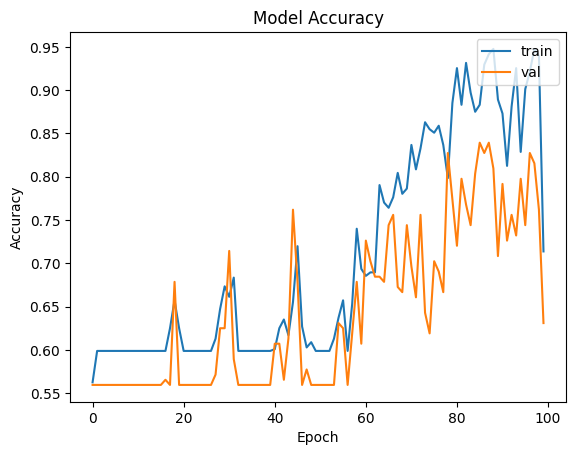

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['main_output_accuracy'])
plt.plot(history.history['val_main_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

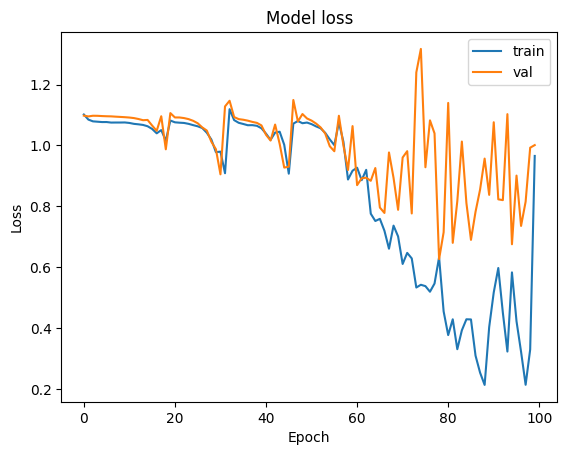

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Prediction

In [20]:
best_model = models.load_model('/kaggle/working/checkpoint/checkpoint.keras')
prediction_model = models.Model(inputs=best_model.input, outputs=best_model.get_layer('main_output').output)

In [21]:
predictions = prediction_model.predict(test_ds)

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 

I0000 00:00:1712544923.880609   17138 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712544923.927173   17138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


In [22]:
prediction_model.compile(loss='binary_crossentropy',
                         optimizer=opt, metrics=['accuracy'])
result = prediction_model.evaluate(test_ds)

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3984 - loss: 610.8334

W0000 00:00:1712544935.463697   17137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 530ms/step - accuracy: 0.4015 - loss: 567.8834


In [23]:
print(f"Model Accuracy on Test set : {result[1]:.3}")

Model Accuracy on Test set : 0.399


/tmp/ipykernel_17087/2090319098.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"{labels[int(y[i])]} (pred : {labels[int(predictions[i])]})")


ValueError: num must be an integer with 1 <= num <= 36, not 37

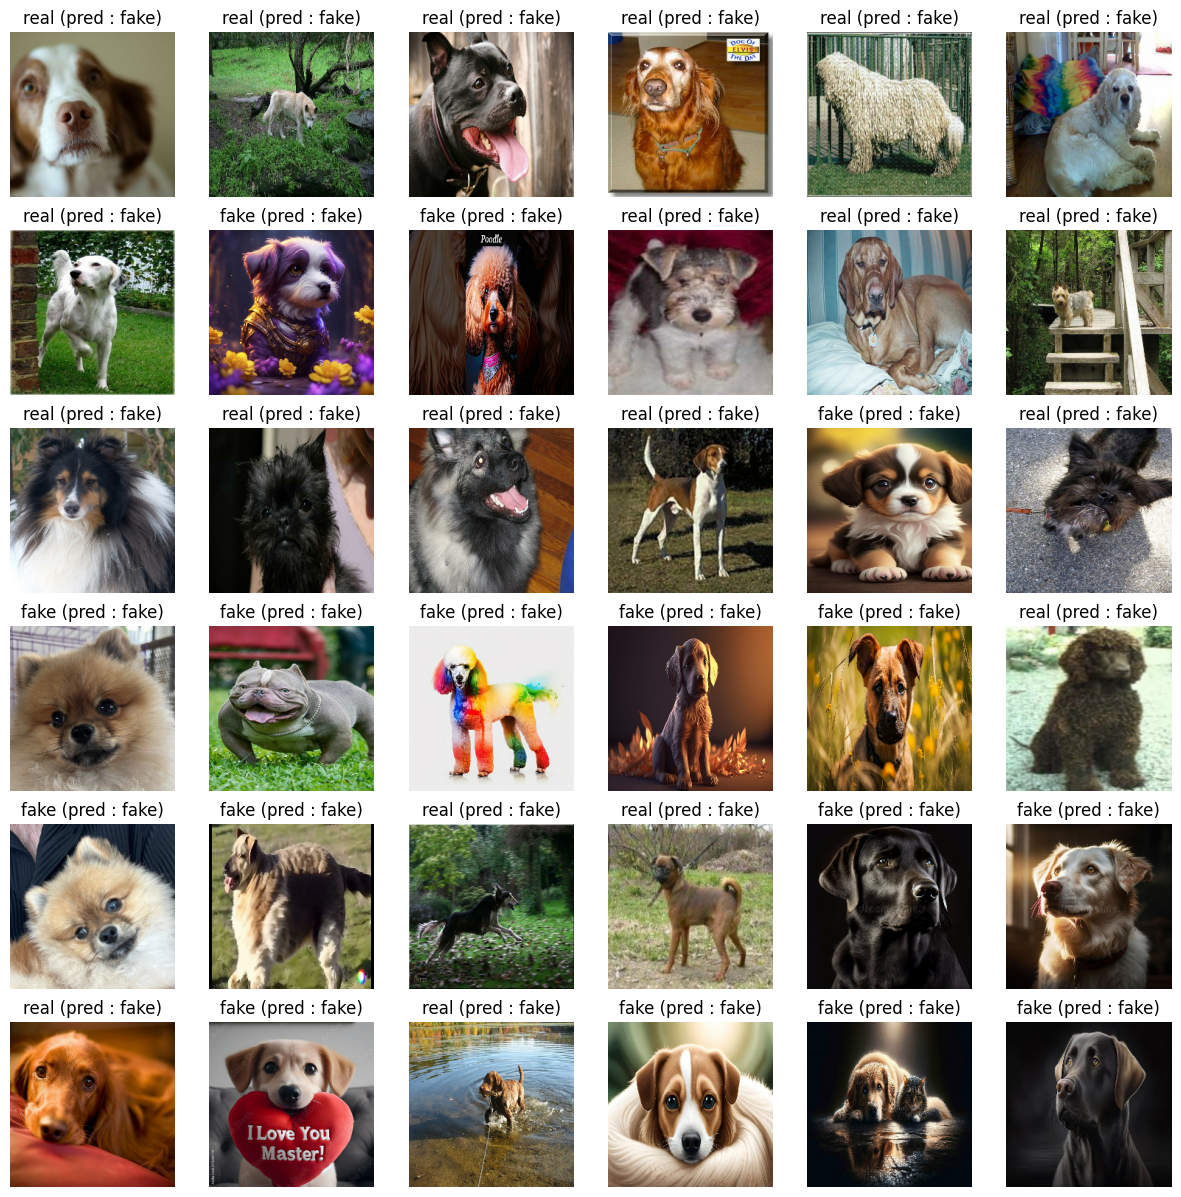

In [24]:
plt.figure(figsize=(15, 15))

for x, y in test_ds:
    for i in range(batch_size):
        ax = plt.subplot(6, 6, i+1)
        plt.imshow(x[i].numpy().astype("uint8"))
        plt.title(f"{labels[int(y[i])]} (pred : {labels[int(predictions[i])]})")
        plt.axis("off")
    break

In [ ]:
import random

plt.figure(figsize=(15, 15))
cnt = 0

for x, y in test_ds:
    
    i = random.randint(0, len(x)-1)
    
    ax = plt.subplot(5, 5, cnt + 1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(f"{labels[int(y[i])]} (pred : {labels[int(predictions[(cnt*batch_size)+i])]})")
    plt.axis("off")
    
    cnt += 1
    if cht > 25:
        break